Loading and preprocessing data using inflated2 salary cap...
Plotting correlation matrix...


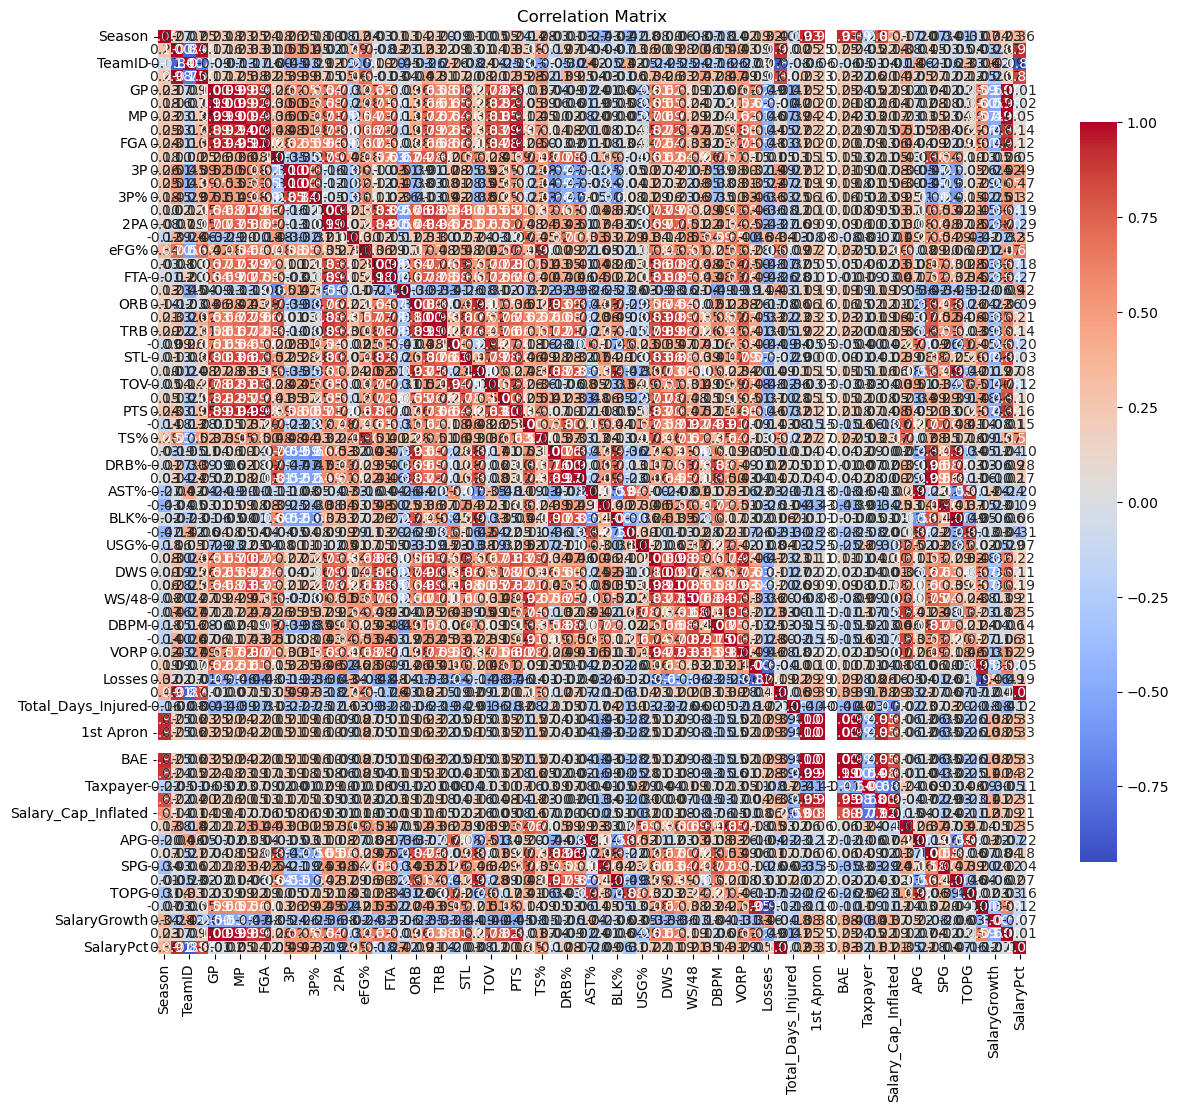

Preparing data for training...
Training models with target variable: SalaryPct
Selected features by RFE: ['Age', 'Years of Service', 'PPG', 'SPG', 'BPG', 'TOPG', '3P%', 'Player', 'Season', 'Team']
Training Random Forest...
Random Forest - Best params: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}
Random Forest - Cross-validation MSE: 0.0030 (+/- 0.0046)
Random Forest - Test MSE: 0.0029, R²: 0.7469

Random Forest - Top 5 important features:
            feature  importance
1  Years of Service    0.282904
0               Age    0.210240
2               PPG    0.128197
9              Team    0.113494
4               BPG    0.107282
Random Forest model saved to '../data/models/Random Forest_salary_prediction_model_inflated2.joblib'
Training Gradient Boosting...
Gradient Boosting - Best params: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200, 'subsample': 1.0}
Gradient Boo

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
import joblib
from sklearn.inspection import permutation_importance

def load_and_preprocess_data(file_path, use_inflated_cap=True):
    data = pd.read_csv(file_path)
    
    if use_inflated_cap:
        data.drop(columns=['Salary Cap'], inplace=True, errors='ignore')
        salary_cap_column = 'Salary_Cap_Inflated'
    else:
        data.drop(columns=['Salary_Cap_Inflated'], inplace=True, errors='ignore')
        salary_cap_column = 'Salary Cap'

    data['Season'] = data['Season'].str[:4].astype(int)

    numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
    imputer = SimpleImputer(strategy='mean')
    data[numerical_cols] = imputer.fit_transform(data[numerical_cols])

    # Feature engineering
    data['PPG'] = data['PTS'] / data['GP']
    data['APG'] = data['AST'] / data['GP']
    data['RPG'] = data['TRB'] / data['GP']
    data['SPG'] = data['STL'] / data['GP']
    data['BPG'] = data['BLK'] / data['GP']
    data['TOPG'] = data['TOV'] / data['GP']
    data['WinPct'] = data['Wins'] / (data['Wins'] + data['Losses'])
    data['SalaryGrowth'] = data.groupby('Player')['Salary'].pct_change().fillna(0)
    data['Availability'] = data['GP'] / 82
    data['SalaryPct'] = data['Salary'] / data[salary_cap_column]

    return data, salary_cap_column

def prepare_data_for_training(data, salary_cap_column):
    # Using Label Encoding for categorical columns
    label_encoders = {}
    for column in ['Player', 'Season', 'Position', 'Team']:
        le = LabelEncoder()
        data[column] = le.fit_transform(data[column])
        label_encoders[column] = le
    
    numerical_cols = data.columns.difference(['Salary', 'SalaryPct'])

    initial_features = ['Age', 'Years of Service', 'GP', 'PPG', 'APG', 'RPG', 'SPG', 'BPG', 'TOPG', 'FG%', '3P%', 'FT%', 'PER', 'WS', 'VORP', 'Availability'] + ['Player', 'Season', 'Position', 'Team']

    data_subset = data[initial_features + ['SalaryPct', 'Salary']].copy()
    data_cleaned = data_subset.dropna()

    return data_cleaned, initial_features, label_encoders

def plot_correlation_matrix(data):
    plt.figure(figsize=(14, 12))
    # Select only the numerical columns
    numerical_data = data.select_dtypes(include=[np.number])
    correlation_matrix = numerical_data.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})
    plt.title("Correlation Matrix")
    plt.show()

def train_models(data_cleaned, initial_features, target_variable='SalaryPct', n_features_to_select=10):
    X = data_cleaned[initial_features]
    y = data_cleaned[target_variable]

    rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=n_features_to_select)
    rfe = rfe.fit(X, y)
    selected_features = [feature for feature, selected in zip(initial_features, rfe.support_) if selected]

    print("Selected features by RFE:", selected_features)

    X = data_cleaned[selected_features]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    models = {
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'Ridge Regression': Ridge(),
        'ElasticNet': ElasticNet(max_iter=10000),
        'SVR': SVR(),
        'Decision Tree': DecisionTreeRegressor(random_state=42)
    }

    param_grids = {
        'Random Forest': {
            'n_estimators': [50, 100, 200],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [8, 10, 12],
            'min_samples_split': [5, 10, 15],
            'min_samples_leaf': [1, 2, 4]
        },
        'Gradient Boosting': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.8, 0.9, 1.0]
        },
        'Ridge Regression': {'alpha': [0.1, 1.0, 10.0, 100.0]},
        'ElasticNet': {'alpha': [0.1, 1.0, 10.0], 'l1_ratio': [0.1, 0.5, 0.9]},
        'SVR': {'C': [0.1, 1, 10], 'epsilon': [0.1, 0.2, 0.5]},
        'Decision Tree': {'max_depth': [6, 8, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
    }

    best_models = {}
    for name, model in models.items():
        print(f"Training {name}...")
        grid_search = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_scaled, y_train)
        best_models[name] = grid_search.best_estimator_
        
        cv_scores = cross_val_score(best_models[name], X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
        print(f"{name} - Best params: {grid_search.best_params_}")
        print(f"{name} - Cross-validation MSE: {-cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        y_pred = best_models[name].predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"{name} - Test MSE: {mse:.4f}, R²: {r2:.4f}")
        
        if name in ['Random Forest', 'Gradient Boosting', 'Decision Tree']:
            importances = best_models[name].feature_importances_
            feature_importance = pd.DataFrame({'feature': selected_features, 'importance': importances})
            feature_importance = feature_importance.sort_values('importance', ascending=False)
            print(f"\n{name} - Top 5 important features:")
            print(feature_importance.head())
        else:
            perm_importance = permutation_importance(best_models[name], X_test_scaled, y_test, n_repeats=10, random_state=42)
            feature_importance = pd.DataFrame({'feature': selected_features, 'importance': perm_importance.importances_mean})
            feature_importance = feature_importance.sort_values('importance', ascending=False)
            print(f"\n{name} - Top 5 important features (Permutation Importance):")
            print(feature_importance.head())
        
        model_filename = f"../data/models/{name}_salary_prediction_model_{'inflated2' if target_variable == 'SalaryPct' else 'regular2'}.joblib"
        joblib.dump(best_models[name], model_filename)
        print(f"{name} model saved to '{model_filename}'")

    return best_models, scaler, selected_features

def main():
    processed_file_path = '../data/processed/nba_player_data_final_inflated.csv'

    use_inflated_cap = input("Use inflated salary cap? (yes/no): ").strip().lower() == 'yes'
    target_variable = input("Choose target variable (SalaryPct/Salary): ").strip()
    
    print(f"Loading and preprocessing data using {'inflated2' if use_inflated_cap else 'regular2'} salary cap...")
    data, salary_cap_column = load_and_preprocess_data(processed_file_path, use_inflated_cap)
    
    print("Plotting correlation matrix...")
    plot_correlation_matrix(data)
    
    print("Preparing data for training...")
    data_cleaned, initial_features, label_encoders = prepare_data_for_training(data, salary_cap_column)
    
    print(f"Training models with target variable: {target_variable}")
    best_models, scaler, selected_features = train_models(data_cleaned, initial_features, target_variable)
    
    print("Model training completed.")

if __name__ == "__main__":
    main()

